In [12]:
import pandas as pd
from sqlalchemy import create_engine
import json

# 접속 정보 로딩 (옵션: db-config.json 파일이 있을 경우)
with open('db-config.json') as f:
    config = json.load(f)

user = config['user']
password = config['password']
host = config['host']
port = config['port']
database = config['database']

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}?charset=utf8mb4")

# vehicle_reg_stats 테이블 데이터 읽어오기
query4 = "SELECT * FROM vehicle_reg_stats"
vehicle = pd.read_sql(query4, con=engine)

# ▶ 결과 확인
vehicle.head()

,id,datetime,region,fuel_type,use_type,reg_count
0,1,2017-01-01,강원,경유,사업용,12362.0
1,2,2017-01-01,광주,전기,비사업용,240.0
2,3,2017-01-01,인천,전기,사업용,6.0
3,4,2017-01-01,인천,전기,비사업용,210.0
4,5,2017-01-01,대구,전기,사업용,53.0


In [13]:
# 사업용 디젤 차량 데이터
diesel_business = vehicle[(vehicle['fuel_type'] == '경유') & (vehicle['use_type'] == '사업용')].copy()

# 전기차 - 사업용
ev_business = vehicle[(vehicle['fuel_type'] == '전기') & (vehicle['use_type'] == '사업용')].copy()

# 전기차 - 비사업용
ev_nonbusiness = vehicle[(vehicle['fuel_type'] == '전기') & (vehicle['use_type'] == '비사업용')].copy()

In [14]:
print(vehicle['fuel_type'].dropna().unique())
print(vehicle['use_type'].dropna().unique())

['경유' '전기' '휘발유']
['사업용' '비사업용']


In [15]:
# vehicle 원본에서 바로 분기
vehicle_raw = pd.read_sql("SELECT * FROM vehicle_reg_stats", con=engine)
vehicle_raw['datetime'] = pd.to_datetime(vehicle_raw['datetime'], errors='coerce')

# 1. 서울만 필터링 (2018년까지)
vehicle_pre_2019 = vehicle_raw[(vehicle_raw['datetime'] <= '2018-12-31') & (vehicle_raw['region'] == '서울')].copy()

# 2. 2019년 1월 데이터 중 구별 연료 비율 구하기
vehicle_over_2019 = vehicle_raw[vehicle_raw['datetime'] >= '2019-01-01'].copy()
base = vehicle_over_2019[vehicle_over_2019['datetime'] == '2019-01-01']
base_ratio = base.groupby(['region', 'fuel_type'])['reg_count'].sum()
base_ratio = base_ratio / base_ratio.groupby('fuel_type').transform('sum')
base_ratio = base_ratio.reset_index().rename(columns={'reg_count': 'ratio'})

# 3. 서울 데이터를 각 구별로 비율 분배
vehicle_pre_2019['fuel_type'] = vehicle_pre_2019['fuel_type'].str.strip()
base_ratio['fuel_type'] = base_ratio['fuel_type'].str.strip()
vehicle_expanded = pd.merge(vehicle_pre_2019, base_ratio, on='fuel_type', how='left')
vehicle_expanded['reg_count'] *= vehicle_expanded['ratio']
vehicle_expanded['region'] = vehicle_expanded['region_y']
vehicle_expanded = vehicle_expanded[['datetime', 'region', 'fuel_type', 'reg_count', 'use_type']]

# 4. 병합 전 데이터로 vehicle 재생성
vehicle = pd.concat([vehicle_expanded, vehicle_over_2019], ignore_index=True)

In [16]:
print(vehicle['fuel_type'].dropna().unique())

['전기' '경유' '휘발유']


In [17]:
# 디젤 사업용 필터링
diesel_business = vehicle[
    (vehicle['fuel_type'] == '경유') & 
    (vehicle['use_type'] == '사업용')
].copy()

# 전기차 전체 (사업용 + 비사업용)
ev_total = vehicle[
    (vehicle['fuel_type'] == '전기')
].copy()


In [18]:
# 그룹화 함수
def get_monthly_sum(df, label):
    df_grouped = df.groupby(pd.Grouper(key='datetime', freq='M'))['reg_count'].sum().reset_index()
    df_grouped['type'] = label
    return df_grouped

diesel_monthly = get_monthly_sum(diesel_business, '디젤_사업용')
ev_monthly = get_monthly_sum(ev_total, '전기차_전체')

C:\Users\USER\AppData\Local\Temp\ipykernel_3812\2181948457.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df.groupby(pd.Grouper(key='datetime', freq='M'))['reg_count'].sum().reset_index()
C:\Users\USER\AppData\Local\Temp\ipykernel_3812\2181948457.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df.groupby(pd.Grouper(key='datetime', freq='M'))['reg_count'].sum().reset_index()


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [9]:
# 2021년 12월 이후 데이터로 필터링
diesel_monthly_filtered = diesel_monthly[diesel_monthly['datetime'] >= '2021-12-01']
ev_monthly_filtered = ev_monthly[ev_monthly['datetime'] >= '2021-12-01']

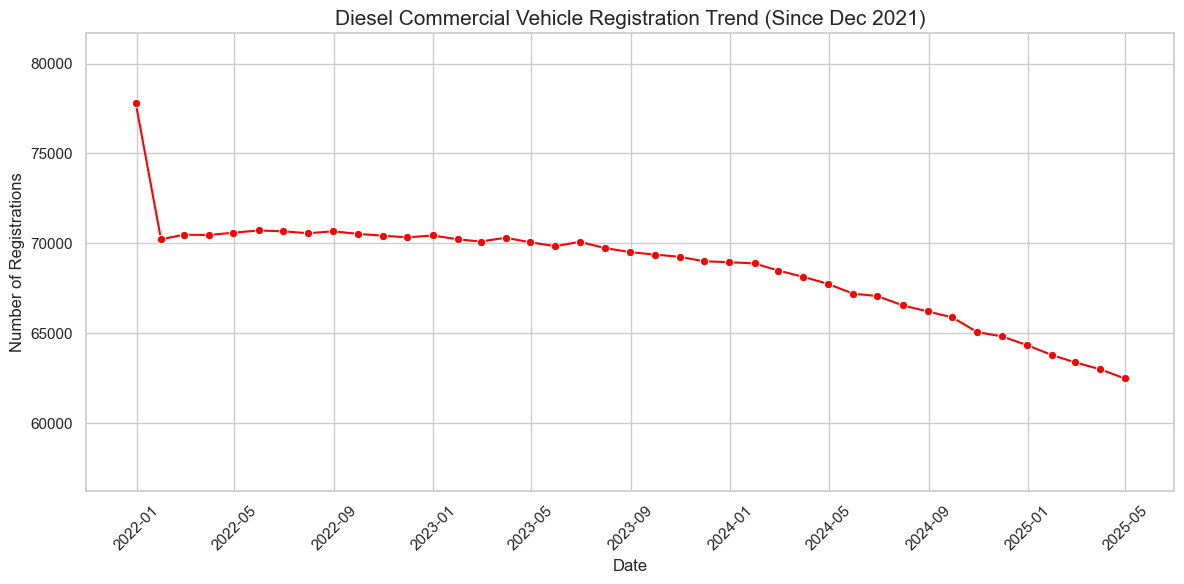

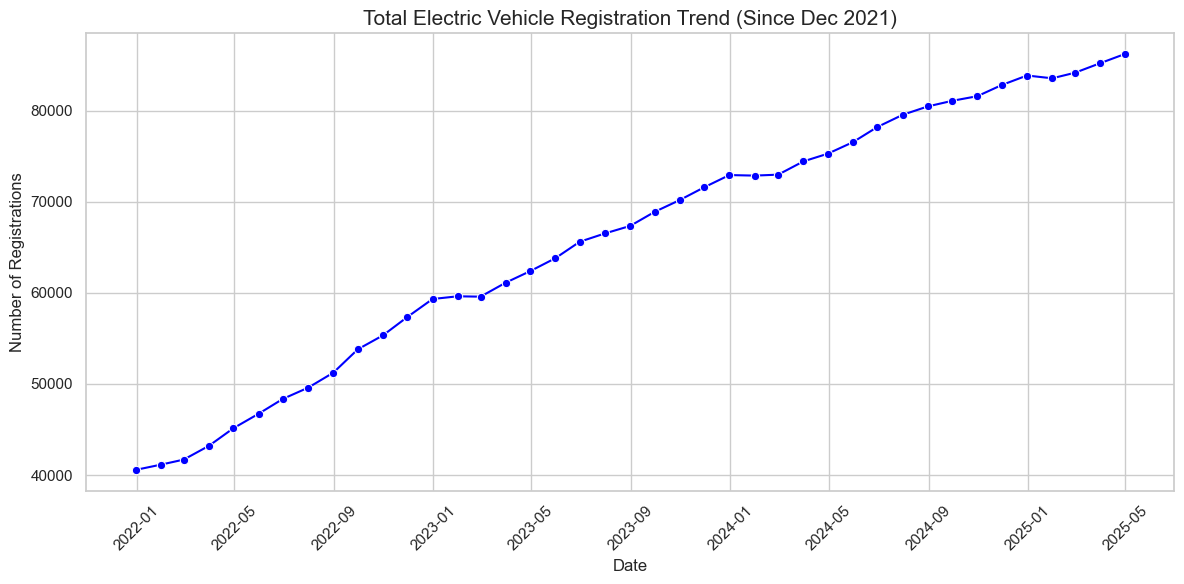

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 스타일
sns.set(style='whitegrid')

# 데이터 필터링 (2021년 12월 이후)
diesel_filtered = diesel_monthly[diesel_monthly['datetime'] >= '2021-12-01']
ev_filtered = ev_monthly[ev_monthly['datetime'] >= '2021-12-01']

# 1. 디젤 사업용 그래프 (스케일 강조)
plt.figure(figsize=(12, 6))
sns.lineplot(data=diesel_filtered, x='datetime', y='reg_count', color='red', marker='o')
plt.title('Diesel Commercial Vehicle Registration Trend (Since Dec 2021)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)

# y축 최대값 조정 (디젤 변화 강조)
plt.ylim(diesel_filtered['reg_count'].min() * 0.9,
         diesel_filtered['reg_count'].max() * 1.05)

plt.tight_layout()
plt.show()

# 2. 전기차 전체 그래프
plt.figure(figsize=(12, 6))
sns.lineplot(data=ev_filtered, x='datetime', y='reg_count', color='blue', marker='o')
plt.title('Total Electric Vehicle Registration Trend (Since Dec 2021)', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
